In [1]:
#authored by Tim (taken from 3/17/24)

In [2]:
#!pip install transformers

In [3]:
import torch
import transformers as ppb
import pandas as pd
import numpy as np


# Install and init BERT model.

In [4]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Process Inputs

In [5]:
import pandas as pd
from ast import literal_eval

books_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv', index_col=[0], converters={"genres": literal_eval})
books_df = books_df[:1000]

In [6]:
books_df['short_description'] = books_df.description.str.slice(0,512)

In [7]:
# TODO 1: @Swathi read the dataset from a Bucket or Google Drive
df = books_df.short_description

In [8]:
tokenized = df.apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))

In [9]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

# Embed Text

In [10]:
#device = torch.device('cuda')
device = torch.device('cpu')

#torch.cuda.set_per_process_memory_fraction(0.70, torch.cuda.device(0))

input_ids = torch.tensor(padded).to(device)
attention_mask = torch.tensor(attention_mask).to(device)
model = model.to(device)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [11]:
embeddings = last_hidden_states[0].cpu().data[:,0,:].numpy()

In [12]:
df.shape, embeddings.shape

((1000,), (1000, 768))

# Save Embeddings

In [13]:
embeddings_pd_df = pd.DataFrame({'book_id': range(df.shape[0])})
embeddings_pd_df['title'] = books_df['title']
embeddings_pd_df['embedding'] = embeddings.tolist()

In [14]:
# TODO 2: @Swathi save embeddings_pd_df to another bucket in JSON format
embeddings_pd_df['embedding'] = embeddings_pd_df['embedding'].apply(lambda x: np.array(x))

In [15]:
embeddings_pd_df.head()

,book_id,title,embedding
0,0,"The Hunger Games (The Hunger Games, #1)","[0.11946997791528702, 0.057541750371456146, 0...."
1,1,Harry Potter and the Sorcerer's Stone (Harry P...,"[-0.3747820258140564, -0.272120863199234, 0.13..."
2,2,"Twilight (Twilight, #1)","[0.12502720952033997, -0.7245563268661499, -0...."
3,3,To Kill a Mockingbird,"[-0.43787631392478943, -0.29154008626937866, -..."
4,4,The Great Gatsby,"[-0.4059893488883972, -0.4704074561595917, -0...."


# Train KNN

In [16]:
# cell edited by Tyler (3/24/2024)

from sklearn.neighbors import NearestNeighbors

# for reproducible results
np.random.seed(1)

# 80/20 train-test split
embedding_vals = np.array(embeddings_pd_df['embedding'].values.tolist())
X_train_inds = np.random.choice(embedding_vals.shape[0], size=int(0.8*embedding_vals.shape[0]), replace=False)
X_test_inds = np.setdiff1d(np.arange(embedding_vals.shape[0]), X_train_inds)

# fit knn model
X_train = embedding_vals[X_train_inds]
k = 5
nn_model = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(X_train)

# Query KNN

In [17]:
query = np.array([X_train[i] + np.random.normal(loc=0.0, scale=1.0, size=X_train[0].shape) for i in range(5)])

In [18]:
distances, indices = nn_model.kneighbors(query)

### Visualize Five Training Queries

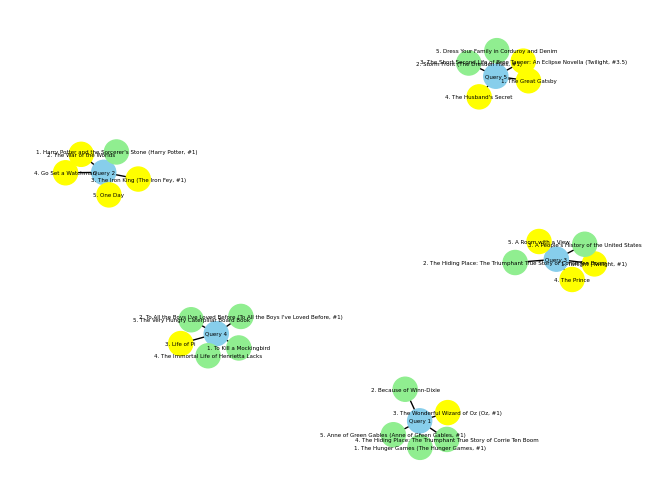

In [19]:
# cell edited by Tyler (4/8/2024)

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# initialize knowledge graph
G = nx.Graph()


i = 0
for book_rec in indices:
    i += 1
    j = 0

    # each query is a node
    G.add_node(f"Query {i}", color='skyblue')
    
    for index in book_rec:
        j += 1

        # color coordinate based on average rating of recommendation
        if books_df.iloc[index]['average_rating'] >= 4.5:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='green')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        elif books_df.iloc[index]['average_rating'] >= 4.0 and books_df.iloc[index]['average_rating'] < 4.5:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='#90EE90')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        elif books_df.iloc[index]['average_rating'] >= 3.0 and books_df.iloc[index]['average_rating'] < 4.0:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='yellow')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        else:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color="red")
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")

# extract node colors
node_colors = [G.nodes[node]["color"] for node in G.nodes()]

# draw knowledge graph of test query results
nx.draw(G, with_labels=True, font_size=4, node_size=300, node_color=node_colors, edge_color='black')

plt.show()

# KNN Model Evaluation

Section authored by Tyler (4/8/2024)

## Test KNN Model

In [20]:
# for reproducible results
np.random.seed(1)

# test knn model
X_test = embedding_vals[X_test_inds]
test_query = np.array([X_test[i] + np.random.normal(loc=0.0, scale=1.0, size=X_test[0].shape) for i in range(X_test.shape[0])])
test_distances, test_indices = nn_model.kneighbors(test_query)


### Visualize 20 Test Queries

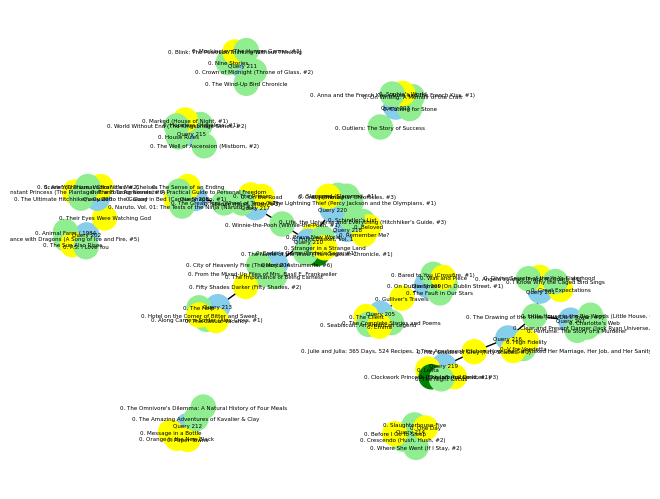

In [41]:
# initialize knowledge graph
G = nx.Graph()

# generate recommendations from test query
i = 0
avg_ratings = list()

# obtain average ratings for each book recommendation for each query
for book_rec in test_indices:
    i += 1
    j = 0
    query_avgs = list()

    for index in book_rec:
        j += 1
        query_avgs.append(books_df.iloc[index]['average_rating'])

    avg_ratings.append(query_avgs)


# randomly select 20 queries to visualize
np.random.seed(1)
queries_to_viz = list(np.random.randint(200, size=20))

for book_rec in test_indices[queries_to_viz, :]:
    i += 1
    j = 0

    # each query is a node
    G.add_node(f"Query {i}", color="skyblue")

    for index in book_rec:
        # color coordinate based on average rating of recommendation
        if books_df.iloc[index]['average_rating'] >= 4.5:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='green')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        elif books_df.iloc[index]['average_rating'] >= 4.0 and books_df.iloc[index]['average_rating'] < 4.5:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='#90EE90')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        elif books_df.iloc[index]['average_rating'] >= 3.0 and books_df.iloc[index]['average_rating'] < 4.0:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color='yellow')
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")
        else:
            # each recommendation is a node
            G.add_node(f"{j}. {embeddings_pd_df.iloc[index]['title']}", color="red")
            # each recommendation will have an edge connected with its associated query
            G.add_edge(f"{j}. {embeddings_pd_df.iloc[index]['title']}", f"Query {i}")


# average rating of each recommendation for each query
avg_ratings = np.array(avg_ratings)

# extract node colors
node_colors = [G.nodes[node]["color"] for node in G.nodes()]

# draw knowledge graph of test query results
nx.draw(G, with_labels=True, font_size=4, node_size=300, node_color=node_colors, edge_color='black')

plt.show()

## Evaluation Metrics From Test Queries

All evaluation metrics used are based on relevance of each book recommendation. Relevance will be ordered by the average rating of each book $\bar{r}_i$. Relevance $rel_i$ is the ranking of each book in the recommendation list (in our case, $max(rel_i) = 4$ and $min(rel_i) = 0$). In cases of simply classifying book recommendations as relevant vs. irrelevant (for MAP@k and MRR), we classify a book recommendation with an average rating greater than or equal to 4.00 relevant, and otherwise irrelevant. We evaluate our BERT-embedded model with the rank-based evaluation metrics listed below:

- **Normalized Discounted Cumulative Gain (nDCG@k):** A measure of how perfectly sorted the top k book recommendations are by relevance. A nDCG@k of 0 is an imperfectly sorted recommendation list, and a nDCG@k of 1 is a perfectly sorted recommendation list.

$$nDCG@k = \frac{\sum_{i=1}^k \frac{2^{rel_i} - 1}{log_2(i+1)}}{\sum_{i=1}^k \frac{2^{k-i} - 1}{log_2(i+1)}}$$

This will be calculated for each query and then we will take the mean of each nDCG@k.

- **Mean Average Precision (MAP@k):** First, for each of the top $k$ recommendations per query,

$$precision@k = \frac{\text{Number of relevant recommendations in the query}}{k}.$$

Then, we obtain the average precision (AP@k) for the number of relevant recommendations $r$ and each of the top $k$ recommendations per query,

$$AP@k = \frac{1}{r}\sum_{i=1}^k precision@i\times R_i$$

where

$$ R_i = \begin{cases} 1 & \text{if recommendation i is relevant} \\ 0  & \text{if recommendation i is irrelevant}\end{cases}.$$

Now, for the matrix of queries $Q$, each row vector of queries $q$, and top $k$ book recommendations per query,

$$MAP@k = \frac{1}{\left| Q \right|}\sum_{q\in Q} AP_q@k.$$

- **Mean Reciprocal Rank (MRR):** We define the reciprocal rank for each query $q$ as

$$RR = \frac{1}{\text{rank of the first relevant recommendation}}.$$

And thus for the matrix of queries $Q$, we have

$$MRR = \frac{1}{\left| Q \right|} \sum_{q\in Q} RR_q.$$

In [42]:
def ndcg(avg_ratings_matrix, k):
    '''
        This function returns the nDCG@k.
    '''
    
    # we start with constructing a relevance matrix
    num_queries = avg_ratings_matrix.shape[0]
    relevance_matrix = np.zeros((num_queries, k))
    
    for query in range(num_queries):
        ratings = avg_ratings_matrix[query,:]
        sorted_ratings = list(np.sort(ratings))
        for recommendation in range(k):
            relevance_matrix[query, recommendation] += sorted_ratings.index(ratings[recommendation])
    
    # ndcg@5 computation
    ndcg_arr = np.zeros(num_queries)
    for i in range(avg_ratings_matrix.shape[0]):
        rel_i = relevance_matrix[i,:]
        ndcg_arr[i] += (((2**rel_i) - 1)/(np.log2(np.arange(k)+2))).sum()/(((2**(np.sort(rel_i)[::-1])) - 1)/(np.log2(np.arange(k)+2))).sum()

    # return the mean ndcg@5
    return ndcg_arr.mean()
    
print(f"Mean nDCG@5: {ndcg(avg_ratings, 5)}")
        

Mean nDCG@5: 0.716873205902207


In [23]:
def map_k(avg_ratings_matrix, k):
    '''
        This function returns the mean average precision.
    '''
    # relevant recommendations
    relevant = np.zeros((avg_ratings_matrix.shape[0], k))
    for i in range(avg_ratings_matrix.shape[0]):
        for j in range(k):
            if avg_ratings_matrix[i, j] >= 4.00:
                relevant[i, j] += 1
    
    # avg precision per query
    precision = np.zeros((avg_ratings_matrix.shape[0], k))
    for i in range(avg_ratings_matrix.shape[0]):
        for j in range(k):
            if relevant[i, j] > 0:
                precision[i, j] += relevant[i, :j].sum()/(j+1)
    ap = np.array([precision[i, :].sum()/relevant[i, :].sum() if relevant[i, :].sum() > 0 else 0 for i in range(avg_ratings_matrix.shape[0])])
    
    # return the mean AP@k (MAP@k)
    return ap.mean()

print(f"MAP@k: {map_k(avg_ratings, 5)}")

MAP@k: 0.25852222222222226


In [24]:
def mrr(avg_ratings_matrix, k):
    '''
        This function returns the mean reciprocal rank.
    '''
    recip_rank_arr = list()

    # reciprocal rank for each query
    for i in range(avg_ratings_matrix.shape[0]):
        for j in range(k):
            if avg_ratings_matrix[i, j] >= 4.00:
                recip_rank_arr.append(1/(j+1))
                break
    

    return np.array(recip_rank_arr).mean()

print(f"MRR: {mrr(avg_ratings, 5)}")

MRR: 0.7576599326599326


The BERT-embedded model sorts recommendations quite well with both nDCG@k and MRR values greater than 0.71. But the MAP@k is a little low with a value of approximately 0.259. This suggests that our BERT-embedded model returns recommendation lists that are mostly sorted by relevance, but the recommendations themselves could be better.